In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import data packages


import statsmodels.api as sm
#import regression packages

In [2]:
d = pd.read_csv('clean_pset1.csv')

In [35]:
#re-define variables from last question

#variable classification

#outcome
y = d['dbrwt'].to_numpy()
#treatment
D = ['tobacco']
D1 = ['cigar6']
#cor with y and D
x1 = ['alcohol', 'mrace3_2', 'mrace3_3', 'ormothhis', 'adequacy', 'cardiac', 'pre4000', 'phyper', 'chyper', 
     'diabetes', 'anemia', 'lung', 'wgain', 'dmeduc', 'dgestat', 'dmage', 'dmar']
#cor with D not y
x2 = []
#cor with y not D
x3 = ['csex', 'totord9', 'isllb10', 'dlivord', 'dplural']

In [31]:
#running logit
vals = sm.Logit(d[D],d[x1+x3])
out = vals.fit()
print(out.summary())

Optimization terminated successfully.
         Current function value: 0.379269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                tobacco   No. Observations:               114610
Model:                          Logit   Df Residuals:                   114588
Method:                           MLE   Df Model:                           21
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.1353
Time:                        10:59:13   Log-Likelihood:                -43468.
converged:                       True   LL-Null:                       -50272.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alcohol        1.7535      0.066     26.563      0.000       1.624       1.883
mrace3_2       1.8595      0.

In [32]:
post = out.predict(d[x1+x3])
d['post'] = post

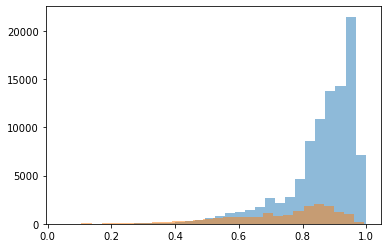

In [33]:
plt.hist(d[d['tobacco']==1]['post'], bins =30, alpha = 0.5)
plt.hist(d[d['tobacco']==0]['post'], bins = 30, alpha = 0.5)
plt.show()

In [38]:
p = ['post']
#predict y using propensity score
vals = sm.OLS(y, sm.add_constant(d[p+x1+x3]))
out = vals.fit()
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     3166.
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:07:52   Log-Likelihood:            -8.6472e+05
No. Observations:              114610   AIC:                         1.729e+06
Df Residuals:                  114586   BIC:                         1.730e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -676.0198     48.528    -13.931      0.0